In [1]:
%matplotlib inline
# %matplotlib widget
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import xarray as xr

from pyxlma.lmalib.traversal import OneToManyTraversal

from tracerpaws.tracktimeseries import open_track_timeseries_dataset, track_polarimetry, add_track_durations, feature_distance_from

In [3]:
track_file = '/home/jovyan/efs/tracer/NEXRAD/tobac_Save_20220807/Track_features_merges.nc'
timeseries_file = '/home/jovyan/efs/tracer/NEXRAD/tobac_Save_20220807/timeseries_data_melt4400.nc'
ref_grid = '/home/jovyan/efs/tracer/NEXRAD/20220807/KHGX20220807_000004_V06_grid.nc'

In [4]:
combo = open_track_timeseries_dataset(track_file, timeseries_file, ref_grid)

In [5]:
csapr_lon, csapr_lat = -95.283893, 29.531782
khgx_lat, khgx_lon = 29.4719, -95.0788
khgx_distance_km = 90.0

# Load and filter to range

In [6]:
# This is copied from the toback_track_histograms script

combo = feature_distance_from(combo, csapr_lon, csapr_lat, 'csapr')
combo = feature_distance_from(combo, khgx_lon, khgx_lat, 'khgx')

# Set up a prunable tree for the track,cell,feature dataset
traversal = OneToManyTraversal(combo, ('track','cell','feature'), ('cell_parent_track_id', 'feature_parent_cell_id'))

# Find tracks IDs with at least one feature within the specified range
feature_in_range = (combo['feature_khgx_dist'] < (khgx_distance_km * 1000.0))
reduced_track_ids = np.unique(combo[{'feature':feature_in_range}].feature_parent_track_id)
combo = traversal.reduce_to_entities('track', reduced_track_ids)

combo = add_track_durations(combo)

# Get dual-pol stats

In [7]:
features_by_track = combo.drop_dims(('x','y','time')).groupby('feature_parent_track_id')
summed_features = features_by_track.sum(dim='feature')
track_membership, track_counts = track_polarimetry(summed_features, zdr_thresh=0.0, kdp_thresh=0.0, flash_thresh=0.0)


In [8]:
track_membership.keys()

dict_keys(['track_has_zdr_kdp_ltg', 'track_has_zdr_kdp_only', 'track_has_zdr_ltg_only', 'track_has_zdr_only', 'track_has_nothing', 'track_has_kdp_only', 'track_has_kdp_ltg_only', 'track_has_ltg_only'])

In [9]:
def track_ids_for_category(cat):
    return track_membership[cat].where(track_membership[cat], drop=True).feature_parent_track_id

def gen_each_track_dataset(track_ds, track_ids):
    traversal = OneToManyTraversal(track_ds, ('track','cell','feature'), ('cell_parent_track_id', 'feature_parent_cell_id'))
    for track_id in track_ids:
        this_track = traversal.reduce_to_entities('track', [track_id])
        yield this_track

In [10]:
ltg_only_track_ids = track_ids_for_category('track_has_ltg_only')

In [11]:
def plot_track_timeseries(track_ds):
    """
    Plot timeseries for the features in track_ds. Expects that
    track_ds has been flitered to be one track, with possibily many
    cells and features.
    
    zdr, kdp volumes
    small flash rate, large flash rate, total flash rate
    feature area
    neighbor count
    """
    track_ds = track_ds.sortby('feature_time')
    tds = track_ds.groupby('feature_time').sum(dim='feature_time')
    print(track_ds.dims, tds.dims)
    t = track_ds.feature_time
    fig, axes = plt.subplots(4,1, figsize=(8.5, 11))
    axes[0].plot(t, track_ds.feature_kdpvol, color='g', label='KDP volume')
    axes[0].plot(t, track_ds.feature_zdrvol, color='b', label='ZDR volume')
    axes[0].legend()
    axes[0].set_ylabel('Volume above melting\nlevel and below\n3 km above melting level\n(500 m Grid boxes)')
    # axes[1].plot(t, track_ds.feature_flash_count, color='k', label='Total flash rate')
    # axes[1].plot(t, track_ds.feature_flash_count_area_LE_4km, color='gray', label='< 4km')
    # axes[1].plot(t, track_ds.feature_flash_count_area_GT_4km, color='r', label='> 4km')
    axes[1].stackplot(t, [track_ds.feature_flash_count_area_GT_4km,
                          track_ds.feature_flash_count_area_LE_4km], 
                      baseline='zero', labels=['> 4 km','< 4 km'])
    axes[1].legend()
    axes[1].set_ylabel('Flash rate (per min)')
    axes[2].plot(t, track_ds.feature_area, color='k', label='Feature area')
    axes[2].legend()
    axes[2].set_ylabel('Feature area (km^2)')
    axes[3].plot(t, track_ds.feature_nearby_count_20km, color='k', label='Neighbors within 20 km')
    axes[3].legend()

    axes[-1].set_xlabel('Time (UTC)')

In [12]:
for one_track in gen_each_track_dataset(combo, ltg_only_track_ids[0:10]):
    plot_track_timeseries(one_track)

ValueError: cannot reduce over dimensions ['feature_time']. expected either '...' to reduce over all dimensions or one or more of Frozen({'feature': 1, 'time': 187, 'y': 1001, 'x': 1001, 'track': 1, 'cell': 2}).

# Plot the feature centroids

In [29]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.dates as mdates

def plot_feature_tracks(track_ds, highlight=None, label_all=False):
    """ Highlight is a list of track_ids to highlight
    
    labels are only shown for highlighted tracks, unless label_all is True
    """
    fig = plt.figure(figsize=(8.5, 8.5),)
    axes = fig.add_subplot(111, projection=ccrs.PlateCarree())
    
    if highlight is not None:
        highlight = set(highlight)
    else:
        highlight = set()
    
    map_alpha=0.5
    from metpy.plots import USCOUNTIES
    county_scales = ['20m', '5m', '500k']
    COUNTIES = USCOUNTIES.with_scale(county_scales[0])
    axes.add_feature(COUNTIES, facecolor='none', edgecolor='gray', alpha=map_alpha)
    axes.add_feature(cfeature.BORDERS, alpha=map_alpha)
    axes.add_feature(cfeature.STATES.with_scale('10m'), alpha=map_alpha)
    gl = axes.gridlines(draw_labels=True)#, xlines=False, ylines=False)
    gl.xlines=False
    gl.ylines=False
    for track in gen_each_track_dataset(track_ds, list(combo.track)):
        this_track_id = int(track.track.values)
        if this_track_id in highlight:
            track_alpha=1.0
            track_lw = 1.5
            axes.text(track.feature_longitude_center[0], track.feature_latitude_center[0],
                      str(this_track_id), fontsize=9)
        else:
            track_alpha=0.2
            track_lw = 0.5
            if label_all is True:
                axes.text(track.feature_longitude_center[0], track.feature_latitude_center[0],
                          str(this_track_id), fontsize=9)
        axes.plot(track.feature_longitude_center, track.feature_latitude_center,
                  color='r', alpha=track_alpha, linewidth=track_lw)
    scart = axes.scatter(combo.feature_longitude_center, combo.feature_latitude_center, 
                         c=mdates.date2num(combo.feature_time.values), alpha=0.5, s=4, marker='o')
    # print(type(combo.feature_time.values), combo.feature_time.values.dtype)
    cbar = plt.colorbar(scart, ax=axes)
    loc = mdates.AutoDateLocator()
    cbar.ax.yaxis.set_major_locator(loc)
    cbar.ax.yaxis.set_major_formatter(mdates.AutoDateFormatter(loc))
    axes.set_xlabel('Longitude (deg)')
    axes.set_ylabel('Latitude (deg)')
    return fig, axes

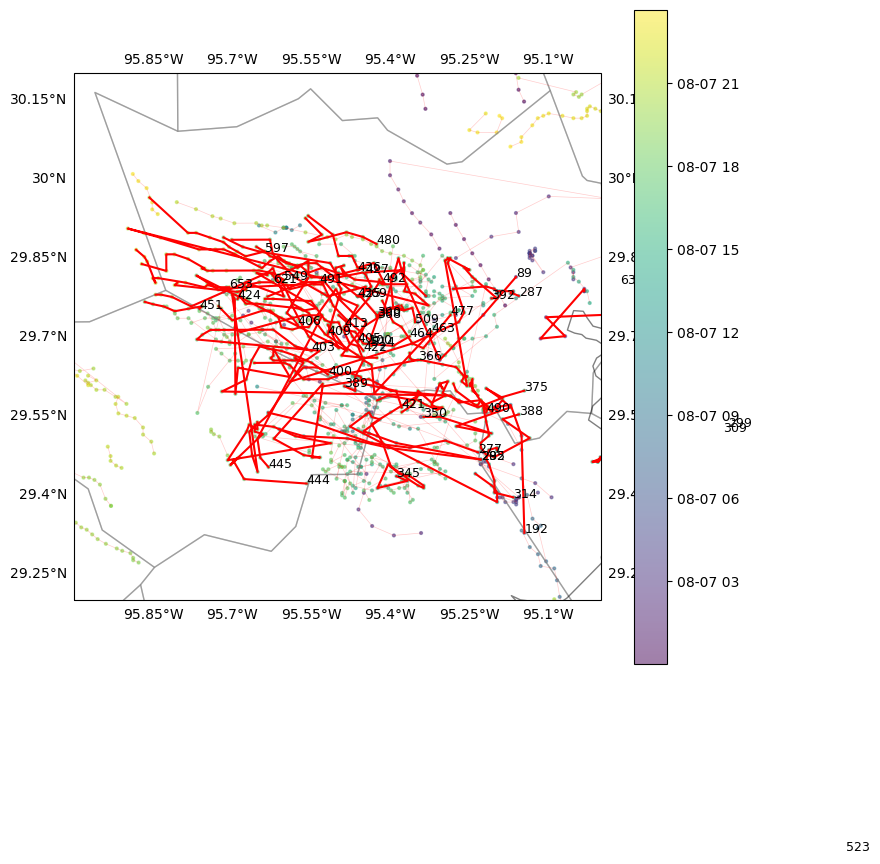

In [40]:
fig, axes = plot_feature_tracks(combo, highlight=ltg_only_track_ids.values)
# axes.set_extent((-95.3, -94.2, 28.0, 29.3))
axes.set_extent((-96, -95.0, 29.2, 30.2))
# fig.tight_layout()

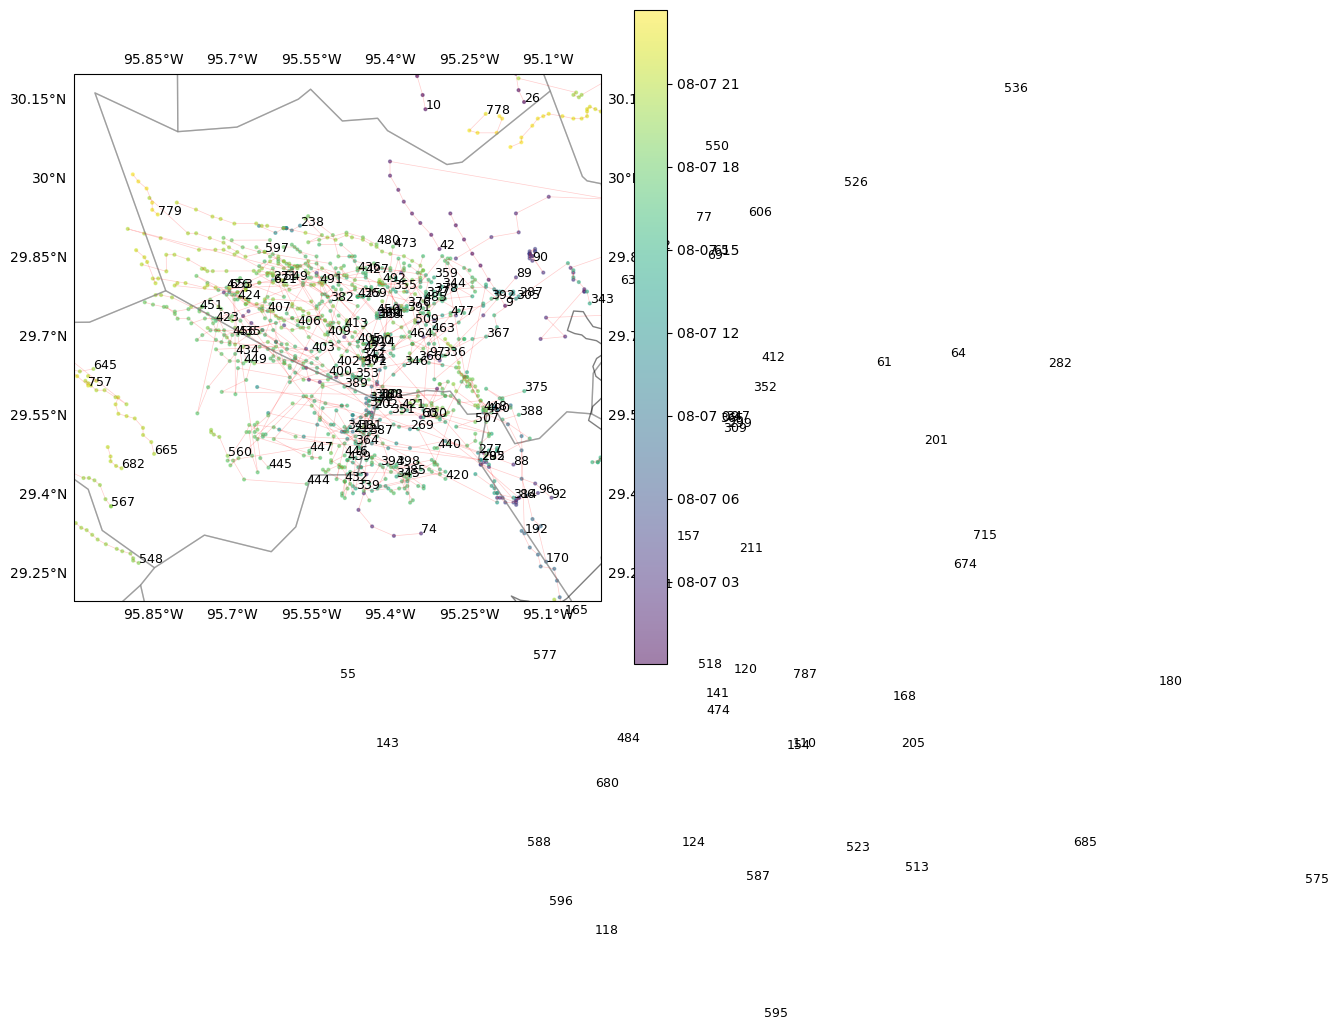

In [39]:
fig, axes = plot_feature_tracks(combo, label_all=True)
# axes.set_extent((-95.3, -94.2, 28.0, 29.3))
axes.set_extent((-96, -95.0, 29.2, 30.2))
# fig.tight_layout()